In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from platform import python_version
print(python_version())

3.8.6


## Load MSKCC fecal sample metadata

In [3]:
df_sample = pd.read_csv("data/tblsamples.csv", index_col=0)[['PatientID','Timepoint','DayRelativeToNearestHCT']]
df_sample.PatientID = df_sample.PatientID.astype(str)
df_sample.head()

,PatientID,Timepoint,DayRelativeToNearestHCT
SampleID,,,
01.BS.01,769,-13.0,-14.0
01.BS.02,769,-8.0,-9.0
01.BS.03,769,-5.0,-6.0
01.BS.04,769,-2.0,-3.0
01.BS.05,769,1.0,0.0


## Add isolated fecal C. parapsilosis isolates to the table

In [4]:
df_isolate = pd.read_excel("data/msk_isolates_fecal_sample.xlsx", header=None, index_col=0).T.set_index('SampleID')
df_isolate['Isolate'] = ['MSK'+str(x) for x in df_isolate.Isolate]
df_isolate = pd.merge(df_sample, df_isolate, left_index=True, right_index=True, how='left')
df_isolate.head()

,PatientID,Timepoint,DayRelativeToNearestHCT,Isolate
SampleID,,,,
01.BS.01,769,-13.0,-14.0,NaN
01.BS.02,769,-8.0,-9.0,NaN
01.BS.03,769,-5.0,-6.0,NaN
01.BS.04,769,-2.0,-3.0,NaN
01.BS.05,769,1.0,0.0,NaN


## Load inStrain clusters

In [5]:
df_cluster = pd.read_csv("data/isolate_clusters_popANI_99_999.csv")
df_cluster.head()

,Isolate,ClusterName,Institute,Location,HR,Weight,PatientID
0,MSK544,0,MSK,USA,True,0.000333,MSK_Pt_14
1,MSK1015,0,MSK,USA,True,0.000333,MSK_Pt_11
2,MSK65,0,MSK,USA,True,0.000333,MSK_Pt_23
3,MSK1119,0,MSK,USA,True,0.000333,MSK_Pt_3
4,MSK67,0,MSK,USA,True,0.000333,MSK_Pt_23


## Load HR phenotype

In [6]:
df_hr = pd.read_csv("data/isolate_hr_phenotype.csv")[['Isolate','HR']]
df_hr = pd.merge(df_isolate.reset_index(), df_hr, left_on='Isolate', right_on='Isolate', how='left')
df_hr = pd.merge(df_hr, df_cluster[['Isolate','ClusterName']], left_on='Isolate', right_on='Isolate', how='left')

# 2105M has two samples taken at day -355 (could not find information of a potential previous BMT)
# the reference date is 3/11/2018， bmt date is 3/1/2019
# the two samples have time points 0， which means that they were wrongly recorded as taken on date 3/11/2018
# it is very likely they were taken on date 3/11/2019
df_hr.loc[(df_hr.PatientID=='2105') & (df_hr.DayRelativeToNearestHCT==-355), 'Timepoint'] = 365
df_hr.loc[(df_hr.PatientID=='2105') & (df_hr.DayRelativeToNearestHCT==-355), 'DayRelativeToNearestHCT'] = 10

# patient 1939 did not go through bmt
# remove this patient
df_hr = df_hr[df_hr.DayRelativeToNearestHCT.notnull()]
df_hr = df_hr[df_hr.HR.notnull()]
df_hr.ClusterName = df_hr.ClusterName.astype(int)

df_hr.head()

,SampleID,PatientID,Timepoint,DayRelativeToNearestHCT,Isolate,HR,ClusterName
2895,1285J,1285,886.0,8.0,MSK2646,True,3
2896,1285J,1285,886.0,8.0,MSK2647,True,3
2897,1285K,1285,889.0,11.0,MSK2648,True,3
2898,1285K,1285,889.0,11.0,MSK2649,True,3
3543,1371H,1371,13.0,6.0,MSK2094,True,0


## Load micafungin exposure data

In [7]:
df_drug = pd.read_csv("data/tbldrug.csv", low_memory=False)
df_drug = df_drug[df_drug.Factor.isin(['micafungin'])]
df_drug.PatientID = df_drug.PatientID.astype(str)
df_drug = df_drug[df_drug.PatientID.isin(list(df_hr.PatientID))]
df_drug.head()

,PatientID,StartTimepoint,StopTimepoint,Factor,Category,AntiInfective,Route,StartDayRelativeToNearestHCT,StopDayRelativeToNearestHCT
107621,1285,873,890,micafungin,antifungals,True,intravenous,-5,12
133620,1371,-3,12,micafungin,antifungals,True,intravenous,-10,5
135686,1380,-2,14,micafungin,antifungals,True,intravenous,-10,6
136155,1380,147,149,micafungin,antifungals,True,intravenous,139,141
145995,1414,-195,-192,micafungin,antifungals,True,intravenous,-191,-188


## Plot phenotype stability

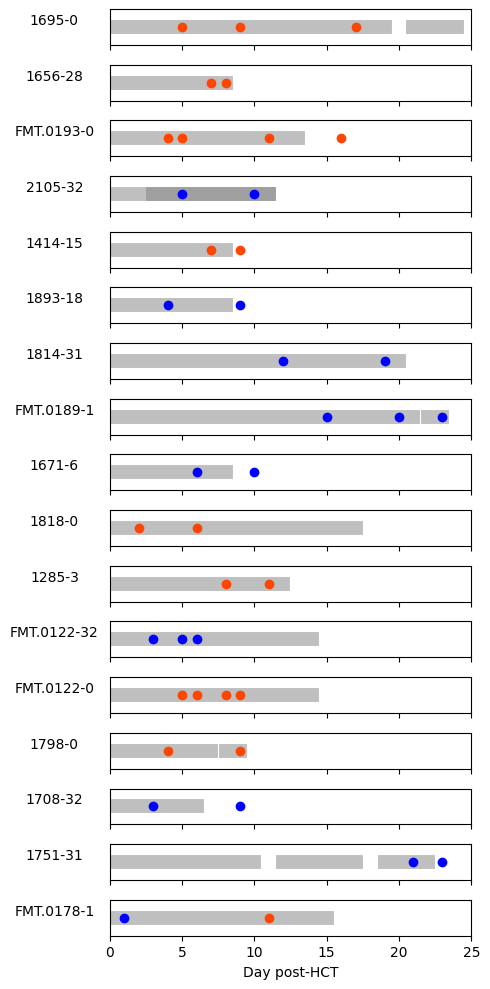

In [8]:
fig, ax = plt.subplots(nrows=17, ncols=1, figsize=(5,10), sharex=True)

color_maps = {
    0:"#0000FF",
    1:"#FF4500",
    0.5:"#15B01A"
}

cluster_index = 0
for pid in ['1695','1656','FMT.0193','2105','1414','1893','1814',
            'FMT.0189','1671','1818','1285','FMT.0122','1798',
            '1708','1751','FMT.0178']:
    df_tmp = df_hr[df_hr.PatientID==pid]
    clusters = []
    for cluster in set(df_tmp.ClusterName):
        df_tmp2 = df_tmp[df_tmp.ClusterName==cluster]
        if len(set(df_tmp2.DayRelativeToNearestHCT))>1:
            days = set(df_tmp2.DayRelativeToNearestHCT)
            for day in days:
                df_tmp3 = df_tmp2[df_tmp2.DayRelativeToNearestHCT==day]
                phenotypes = list(set(df_tmp3.HR))
                if len(phenotypes)==1:
                    phenotype = phenotypes[0]
                elif len(phenotypes)==2:
                    phenotype = 0.5
                else:
                    print("should not come here")
                    assert 0
                _ = ax[cluster_index].scatter(day, 0, color=color_maps[phenotype])
            _ = ax[cluster_index].set_yticks([])
            _ = ax[cluster_index].set_ylabel("%s-%d"%(pid, cluster), rotation=0, labelpad=40)

            # plot micafungin period
            df_drug2 = df_drug[(df_drug.PatientID==pid)]
            for startday,stopday in zip(df_drug2.StartDayRelativeToNearestHCT, df_drug2.StopDayRelativeToNearestHCT):
                _ = ax[cluster_index].plot([startday,stopday], [0,0], linewidth=10, color='gray', alpha=0.5, zorder=-100)
            _ = ax[cluster_index].set_xlim([0,25])
            
            cluster_index += 1
_ = ax[cluster_index-1].set_xlabel("Day post-HCT")

plt.tight_layout()
plt.savefig("output/hr_temporal_stability.png", dpi=600, bbox_inches="tight")